In [6]:
import calc_footprint_FFP_climatology as myfootprint_s
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import rasterio
import cv2
from affine import Affine
import pyproj as proj
import os
import datetime as dt
import scipy
import os

In [3]:
def date_parse(yr,doy,hr):
    '''
    Standard date parser (pd.read_csv) for flux table outputs
    '''
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')
    
def date_parse_sigv_17(doy,hr):
    '''
    Sigv date parser (pd.read_csv) for 2017
    '''
    yr='2017'
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')


def date_parse_sigv_18(doy,hr):
    '''
    Sigv date parser (pd.read_csv) for 2018
    '''
    yr='2018'
    if '2400' in hr:
        hr = '000'
        return pd.datetime.strptime(f'{yr}{int(doy)+1}{int(hr):04}', '%Y%j%H%M')
    else:
        return pd.datetime.strptime(f'{yr}{doy}{int(hr):04}', '%Y%j%H%M')
    
def mask_fp_cutoff(f_array,cutoff=.9):
    '''
    Returns a np.ndarray that cuts off values below the cumulative .9 threshold
    with nans set to zero
    
    Inputs:
        f_array : 2-D array of point footprint weights [unitless]
        
    Outputs:
        2-D np.ndarray
    '''
    val_array = f_array.flatten()
    sort_df = pd.DataFrame({'f':val_array}).sort_values(by='f').iloc[::-1]
    sort_df['cumsum_f'] = sort_df['f'].cumsum()
    
    sort_group = sort_df.groupby('f',as_index=True).mean()
    diff = abs(sort_group['cumsum_f']-cutoff)
    sum_cutoff = diff.idxmin()
    f_array = np.where(f_array>=sum_cutoff,f_array,np.nan)
    f_array[~np.isfinite(f_array)] = 0.00000000e+000
    
    return f_array

def find_transform(xs,ys):
    '''
    Returns the affine transform for 2d arrays xs and ys
    
    Inputs:
        xs : 2-d grid of x coordinates (usually utm)
        ys : 2-d grid of y coordinates (usually utm)
        
    Outputs:
        aff_transform : affine.Affine object
    '''

    shape = xs.shape

    #Choose points to calculate affine transform
    y_points = [0, 0, shape[0] - 1]
    x_points = [0, shape[0] - 1, shape[1] - 1]
    in_xy = np.float32([[i, j] for i, j in zip(x_points, y_points)])
    out_xy = np.float32([[xs[i, j], ys[i, j]] for i, j in zip(y_points, x_points)])
    

    #Calculate affine transform
    aff_transform = Affine(*cv2.getAffineTransform(in_xy,out_xy).flatten())

    return aff_transform

In [10]:
#Name paths to flux and sigv tables
base_dir = '/Users/miksch/Thesis_Files/Processed/Eagle_Lake/EL_eb'
sigv_2017 = os.path.join(base_dir,'ls8_var_2017.csv')
sigv_2018 = os.path.join(base_dir,'ls8_var_2018.csv')
fluxes = os.path.join(base_dir,'ls8_flux.csv')

#Read in flux and sigv data
flux_df = pd.read_csv(fluxes, delim_whitespace=True, parse_dates={'TIMESTAMP':[0,1,2]}, date_parser=date_parse,
                      index_col=0, na_values=['*****'])
sigv_df_2017 = pd.read_csv(sigv_2017,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]}, 
                           date_parser=date_parse_sigv_17, index_col=0, names=['DOY','hrmin','mag_v','sig_v'])
sigv_df_2018 = pd.read_csv(sigv_2018,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]}, 
                           date_parser=date_parse_sigv_18, index_col=0, names=['DOY','hrmin','mag_v','sig_v'])

#Concat dataframes and select day of year you want to make footprint for (doy)
doy = 254
sigv_df = pd.concat([sigv_df_2017,sigv_df_2018])
full_df = pd.concat([flux_df,sigv_df],axis=1)
temp_df = full_df[full_df.index.dayofyear == doy].copy()

In [11]:
#Model parameters
zm_s = 2.78 #Measurement height [m]
h_c = 0.05 #Height of canopy [m]
h_s = 2000. #Height of boundary layer [m]
data['ol'] = zm_s/data['z_L'] #Monin-Obukhov length [m]
dx = 3. #Model resolution [m]
origin_d = 600. #Model bounds distance from origin [m]
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1) #np.ndarray of hours

#Loop through each day in the dataframe
for doy in full_df.index.dayofyear.drop_duplicates().values:
    
    #Subset dataframe to only values in day of year
    print(f'Day of year: {doy}')
    temp_df = full_df[full_df.index.dayofyear == doy]
    
    d = (2./3.) * h_c


    for indx,t in enumerate(hours):
        
        print(f'Hour: {t}')

        try:

            temp_line = temp_df.loc[temp_df.index.hour == t,:]
               
            #Calculate footprint
            temp_ffp = myfootprint_s.FFP_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                    zm=zm_s-d, z0=h_c*.123, h=h_s, rs=None,
                                    ol=temp_line['ol'].values,sigmav=temp_line['SDVn'].values,
                                    ustar=temp_line['ustar'].values,
                                    wind_dir=temp_line['Dir'].values,
                                    crop=0,fig=0,verbosity=0)

            f_2d = np.array(temp_ffp['fclim_2d'])
            x_2d = np.array(temp_ffp['x_2d']) + station_x
            y_2d = np.array(temp_ffp['y_2d']) + station_y
            f_2d = f_2d*dx**2

            #Calculate affine transform for given x_2d and y_2d
            affine_transform = ff.find_transform(x_2d,y_2d)
            
            #Create data file if not already created
            if new_dat is None:
                out_f = os.path.join('output','utm_footprints',f'{doy}_{station}.tif')
                print(f_2d.shape)
                new_dat = rasterio.open(out_f,'w',driver='GTiff',dtype=rasterio.float64,
                                        count=len(hours),height=f_2d.shape[0],width=f_2d.shape[1],
                                        transform=affine_transform,
                                        crs=out_proj.srs,
                                        nodata=0.00000000e+000)

        except Exception as e:

            print(f'Hour {t} footprint failed, band {band} not written.')

            temp_ffp = None

            continue

        #Mask out points that are below a % threshold (defaults to 90%)
        f_2d = ff.mask_fp_cutoff(f_2d)



        
    print()

                       Ta   Td       D  stdTa    Dir    V  ustar    z/L     H  \
TIMESTAMP                                                                       
2018-09-11 01:00:00  17.9  4.0  1233.2  0.520   87.3  0.7   0.08  0.311  -4.5   
2018-09-11 02:00:00  17.8  3.4  1263.7  0.580   53.9  0.8   0.15 -0.200  18.8   
2018-09-11 03:00:00  15.9  3.4  1031.6  0.572  107.8  0.7   0.13 -0.079   4.8   
2018-09-11 04:00:00  15.8  2.4  1070.1  0.904  109.4  0.9   0.11  0.331 -11.9   
2018-09-11 05:00:00  13.9  5.5   682.9  1.010  137.6  0.6   0.08 -0.679   8.4   
2018-09-11 06:00:00  14.2  5.5   719.3  0.740  144.4  0.8   0.04  4.720  -9.2   
2018-09-11 07:00:00  15.3  4.2   911.2  0.834  125.5  1.9   0.10  1.064 -29.9   
2018-09-11 08:00:00  18.1  4.5  1231.9  1.158  138.7  1.7   0.11 -0.109   4.4   
2018-09-11 09:00:00  20.2  4.7  1518.0  0.574  118.6  1.0   0.14  0.155 -12.5   
2018-09-11 10:00:00  21.7  4.7  1746.7  0.537  170.0  0.2   0.16 -0.108  11.0   
2018-09-11 11:00:00  23.2  6

In [26]:
zm_s = 2.78 #Measurement height [m]
h_c = 0.05 #Height of canopy [m]
h_s = 2000. #Height of boundary layer [m]
temp_df['ol'] = zm_s/temp_df['z/L'] #Monin-Obukhov length [m]
dx = 3. #Model resolution [m]
origin_d = 600. #Model distance from origin [m]


#Convert local lat/lon to local UTM (Eagle Lake: UTM 12)
station_coord = (-112.050747,41.166695) #Eagle Lake lat/lon in WGS-84
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:32612')
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

new_dat = None

#Index within your dataframe that you want to make a footprint of
indx = 7
t = temp_df.index[indx]
hr = t.hour
print(t)

try:

    temp_line = temp_df.loc[t,:]

    #If you're debugging, verbosity=2 will give you error output from the model
    temp_ffp = myfootprint_s.FFP_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                            zm=zm_s,z0=h_c*.15,h=h_s,rs=None,
                            ol=temp_line['ol'],sigmav=temp_line['sig_v'],umean=temp_line['V'],
                            ustar=temp_line['ustar'],wind_dir=temp_line['Dir'],
                            crop=0,fig=0,verbosity=0) 
    
    f_2d = np.array(temp_ffp['fclim_2d'])
    x_2d = np.array(temp_ffp['x_2d']) + station_x
    y_2d = np.array(temp_ffp['y_2d']) + station_y
    f_2d = f_2d*dx**2

    #Calculate affine transform for given x_2d and y_2d
    affine_transform = find_transform(x_2d,y_2d)

    if new_dat is None:
        #First input to the function is the output file name
        #Change the crs to whatever utm you are in as a proj4 string
        new_dat = rasterio.open('test_footprint.tif','w',driver='GTiff',dtype=rasterio.float64,
                                count=1,height=f_2d.shape[0],width=f_2d.shape[1],
                                transform=affine_transform,
                                crs='+proj=utm +zone=12 +ellps=WGS84 +datum=WGS84 +units=m +no_defs',
                                nodata=0.00000000e+000)

except Exception as e:

    print(e)
    print(f'Hour {hr} footprint failed')

    temp_ffp = None


#Mask out points that are below a % threshold (defaults to 90%)
f_2d = mask_fp_cutoff(f_2d,cutoff=.8)

#Write the new band
new_dat.write(f_2d,1)

#Update tags with metadata
tag_dict = {'hour':f'{t.hour*100:04}',
            'wind_dir':temp_line['Dir'],
            'total_footprint':np.nansum(f_2d)}
new_dat.update_tags(1,**tag_dict)
       
#new_dat.close()
#new_dat = None

2018-09-11 08:00:00


In [27]:
np.where(f_2d>0.,f_2d,np.nan)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

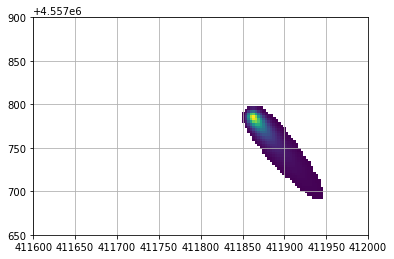

In [29]:
fig,ax = plt.subplots()
ax.pcolormesh(x_2d,y_2d,np.where(f_2d>0.,f_2d,np.nan))
ax.set_xlim(411600, 412000)
ax.set_ylim(4557650, 4557900)
ax.grid()
plt.show()